# Skill estimation and outcome prediction using graphical models

In this project we are going to use graphical models to do some skill estimation amongst the players and using this model try to predict the outcome of certain matches in the tournament. We will first import data from an actual chess tournament along with the wins and losses for every round (for each player at least out of a maximum 7). Using this data we wil train our model using the first few rounds and try to predict the outcome for the remaining.

In [1]:
import pyGMs as gm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline         

### Loading the data of games & outcomes

In [2]:
import pandas as pd
# Create a dataframe from csv
df = pd.read_csv('Chess_Player_Matches.csv', delimiter=',')
# Create a list of tuples for dataframe
games = [list(row) for row in df.values]


In [3]:
nplayers = max( [max(g[0],g[1]) for g in games] )

In [4]:
nplayers

64

In [5]:
performance_ratings = np.zeros(nplayers+1)

for item in games:
    performance_ratings[item[3]] = item[4]
    if item[2] == 'W':
        item[2] = 1
    elif item[2] == 'L':
        item[2] = -1
    elif item[2] == 'D':
        item[2] = 0


In [6]:
games
#player_num	round	outcome	opponent_num	opponent_pre_rating


[[1, 1, 1, 39, 1436],
 [1, 2, 1, 21, 1563],
 [1, 3, 1, 18, 1600],
 [1, 4, 1, 14, 1610],
 [1, 5, 1, 7, 1649],
 [1, 6, 0, 12, 1663],
 [1, 7, 0, 4, 1716],
 [2, 1, 1, 63, 1175],
 [2, 2, 1, 58, 917],
 [2, 3, -1, 4, 1716],
 [2, 4, 1, 17, 1629],
 [2, 5, 1, 16, 1604],
 [2, 6, 1, 20, 1595],
 [2, 7, 1, 7, 1649],
 [3, 1, -1, 8, 1641],
 [3, 2, 1, 61, 955],
 [3, 3, 1, 25, 1745],
 [3, 4, 1, 21, 1563],
 [3, 5, 1, 11, 1712],
 [3, 6, 1, 13, 1666],
 [3, 7, 1, 12, 1663],
 [4, 1, 1, 23, 1363],
 [4, 2, 0, 28, 1507],
 [4, 3, 1, 2, 1553],
 [4, 4, 1, 26, 1579],
 [4, 5, 0, 5, 1655],
 [4, 6, 1, 19, 1564],
 [4, 7, 0, 1, 1794],
 [5, 1, 1, 45, 1242],
 [5, 2, 1, 37, 980],
 [5, 3, 0, 12, 1663],
 [5, 4, 0, 13, 1666],
 [5, 5, 0, 4, 1716],
 [5, 6, 1, 14, 1610],
 [5, 7, 1, 17, 1629],
 [6, 1, 1, 34, 1399],
 [6, 2, 0, 29, 1602],
 [6, 3, -1, 11, 1712],
 [6, 4, 1, 35, 1438],
 [6, 5, 0, 10, 1365],
 [6, 6, 1, 27, 1552],
 [6, 7, 1, 21, 1563],
 [7, 1, 1, 57, 1092],
 [7, 2, 1, 46, 377],
 [7, 3, 1, 13, 1666],
 [7, 4, 1, 11, 1712]

### Win probability and graphical model

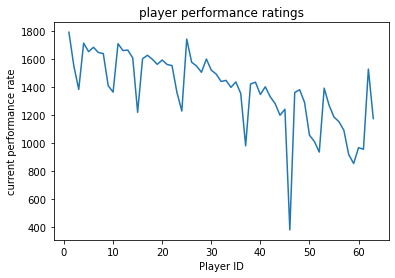

In [7]:
#g[0]=player, g[3]=opponent
nplayers = max( [max(g[0],g[3]) for g in games] )+1 
nlevels = 10   # let's say 10 discrete skill levels
scale = .064 # this scales how skill difference translates to win probability
# Make variables for each player; value = skill level
X = [None]*nplayers
for i in range(nplayers):
    X[i] = gm.Var(i, nlevels) 

plt.plot(X[1:64],performance_ratings[1:64])
plt.title('player performance ratings')
plt.xlabel('Player ID')
plt.ylabel('current performance rate')
plt.show()

# Information from each game: what does Pi winning over Pj tell us?
#    Win probability  Pr[win | Xi-Xj]  depends on skill difference of players
Pwin = np.zeros( (nlevels,nlevels) )
for i in range(nlevels):
    for j in range(nlevels):
        diff = i-j                   # find the advantage of Pi over Pj, then 
        Pwin[i,j] = (1./(1+np.exp(-scale*diff)))  # Pwin = logistic of advantage

# before any games, uniform belief over skill levels for each player:
factors = [ gm.Factor([X[i]],1./nlevels) for i in range(nplayers) ]

# Now add the information from each game:
for g in games:
#     print(g[2])
    P1,P2,win = g[0],g[3],g[2]
    if P1>P2: P1,P2,win=P2,P1,-win  # (need to make player IDs sorted...)
    factors.append(gm.Factor([X[P1],X[P2]], Pwin if win>0 else 1-Pwin) )
    performance_ratings[g[0]] +=  400 * (g[2])

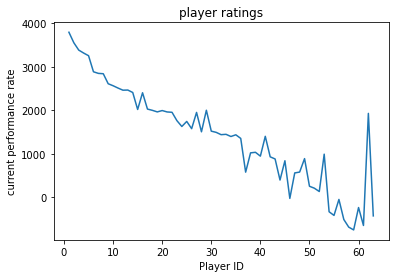

In [8]:
performance_ratings[g[0]] +=  400 * (g[2])
plt.plot(X[1:64],performance_ratings[1:64])
plt.title('player ratings')
plt.xlabel('Player ID')
plt.ylabel('current performance rate')
plt.show()
for i in range(nplayers):
    performance_ratings[i] += performance_ratings[i]/ 7


In [9]:
performance_ratings

array([    0.        ,  4336.        ,  4060.57142857,  3867.42857143,
        3789.71428571,  3720.        ,  3298.28571429,  3256.        ,
        3246.85714286,  2984.        ,  2931.42857143,  2870.85714286,
        2814.85714286,  2818.28571429,  2754.28571429,  2308.57142857,
        2747.42857143,  2318.85714286,  2285.71428571,  2244.57142857,
        2280.        ,  2243.42857143,  2234.28571429,  2014.85714286,
        1861.71428571,  1994.28571429,  1804.57142857,  2230.85714286,
        1722.28571429,  2288.        ,  1739.42857143,  1707.42857143,
        1646.85714286,  1656.        ,  1598.85714286,  1643.42857143,
        1548.57142857,   662.85714286,  1169.14285714,  1184.        ,
        1083.42857143,  1603.42857143,  1065.14285714,  1009.14285714,
         456.        ,   962.28571429,   -26.28571429,   642.28571429,
         665.14285714,  1018.28571429,   292.57142857,   241.14285714,
         154.28571429,  1134.85714286,  -377.14285714,  -473.14285714,
      

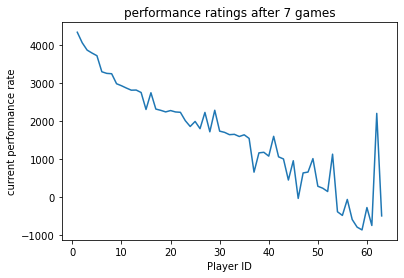

In [10]:
plt.plot(X[1:64],performance_ratings[1:64])
plt.title('performance ratings after 7 games')
plt.xlabel('Player ID')
plt.ylabel('current performance rate')
plt.show()

In [11]:
Pwin

array([[0.5       , 0.48400546, 0.46804362, 0.45214691, 0.43634725,
        0.42067575, 0.40516251, 0.38983639, 0.3747248 , 0.35985351],
       [0.51599454, 0.5       , 0.48400546, 0.46804362, 0.45214691,
        0.43634725, 0.42067575, 0.40516251, 0.38983639, 0.3747248 ],
       [0.53195638, 0.51599454, 0.5       , 0.48400546, 0.46804362,
        0.45214691, 0.43634725, 0.42067575, 0.40516251, 0.38983639],
       [0.54785309, 0.53195638, 0.51599454, 0.5       , 0.48400546,
        0.46804362, 0.45214691, 0.43634725, 0.42067575, 0.40516251],
       [0.56365275, 0.54785309, 0.53195638, 0.51599454, 0.5       ,
        0.48400546, 0.46804362, 0.45214691, 0.43634725, 0.42067575],
       [0.57932425, 0.56365275, 0.54785309, 0.53195638, 0.51599454,
        0.5       , 0.48400546, 0.46804362, 0.45214691, 0.43634725],
       [0.59483749, 0.57932425, 0.56365275, 0.54785309, 0.53195638,
        0.51599454, 0.5       , 0.48400546, 0.46804362, 0.45214691],
       [0.61016361, 0.59483749, 0.5793242

In [12]:
model = gm.GraphModel(factors)
model.makeMinimal()  # merge any duplicate factors (e.g., repeated games)

In [13]:
if model.nvar < 0:       # for very small models, we can do brute force inference:
    jt = model.joint()
    jt /= jt.sum()       # normalize the distribution and marginalize the table
    bel = [jt.marginal([i]) for i in range(nplayers)] 
else:                    # otherwise we need to use some approximate inference:
    from pyGMs.messagepass import LBP, NMF
    lnZ,bel = LBP(model, maxIter=10, verbose=True)   # loopy BP
    #lnZ,bel = NMF(model, maxIter=10, verbose=True)  # Mean field

Iter 1: -253.74523760175262
Iter 2: -278.64628549038645
Iter 3: -280.5017713968642
Iter 4: -280.5508363628496
Iter 5: -280.5515698378412
Iter 6: -280.5515722597275
Iter 7: -280.551572286672
Iter 8: -280.5515723436847
Iter 9: -280.55157235003196
Iter 10: -280.5515723505873


The normalization constant, $\log(Z)$, represents the (log) probability of evidence for our model, namely the probability of the observed game outcomes given our parameters, etc.  We could experiment with changing the win probability function or its scaling parameter to try to make our model better fit the data using this value.


###  Ranking players by predicted skill

Mean skill estimates: 
player 1: 0.45
player 2: 0.6014
player 3: 0.6719
player 4: 0.6737
player 5: 0.6019
player 6: 0.5987
player 7: 0.507
player 8: 0.5998
player 9: 0.5993
player 10: 0.595
player 11: 0.5949
player 12: 0.5046999999999999
player 13: 0.6388
player 14: 0.603
player 15: 0.5032
player 16: 0.4989
player 17: 0.6013
player 18: 0.5035999999999999
player 19: 0.5065999999999999
player 20: 0.5104
player 21: 0.5042
player 22: 0.5021
player 23: 0.45010000000000006
player 24: 0.4988
player 25: 0.49400000000000005
player 26: 0.4064
player 27: 0.40380000000000005
player 28: 0.5506
player 29: 0.5088
player 30: 0.5477000000000001
player 31: 0.3927
player 32: 0.3937
player 33: 0.5002
player 34: 0.4043
player 35: 0.5018
player 36: 0.3934
player 37: 0.5501
player 38: 0.4025
player 39: 0.4563
player 40: 0.40069999999999995
player 41: 0.3948
player 42: 0.4457
player 43: 0.29860000000000003
player 44: 0.39449999999999996
player 45: 0.3489
player 46: 0.2994
player 47: 0.3989
player 48: 0.3075
p

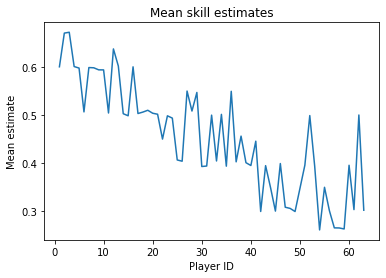

In [18]:
print("Mean skill estimates: ")
scores = np.zeros(nplayers)
for i in range(nplayers):
    scores[i] = round(bel[i].table.dot(np.arange(nlevels)),3)/10
    print("player " + str(i+1) + ": "+str(round(bel[i].table.dot(np.arange(nlevels)),3)/10))
accuracies_mean = np.array([np.mean(v) for v in bel])
print(scores)
plt.plot(X[1:64], scores[1:64])
plt.title('Mean skill estimates')
plt.xlabel('Player ID')
plt.ylabel('Mean estimate')
plt.show()

### Predicting match outcomes

In [15]:
scores1 = np.zeros(nplayers)
scores2 = np.zeros(nplayers)

for i in range(1,64):
    for j in range(1,64):
        if (i!=j):
            print("Estimated probability P{} beats P{} next time:".format(i,j))
            # Expected value (over skill of P0, P1) of Pr[win | P0-P1]
            if i<j:
                scores1[i] = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],Pwin)).table.sum()
                print( (bel[i]*bel[j]*gm.Factor([X[i],X[j]],Pwin)).table.sum() )
            elif i>j:
                scores2[i] = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],Pwin)).table.sum()
                print( (bel[i]*bel[j]*gm.Factor([X[i],X[j]],1-Pwin)).table.sum() )

# Notes: we should probably use the joint belief over Xi and Xj, but for simplicity
#  with approximate inference we'll just use the estimated singleton marginals

Estimated probability P1 beats P2 next time:
0.48884879697880607
Estimated probability P1 beats P3 next time:
0.48855292400942146
Estimated probability P1 beats P4 next time:
0.49991458757818985
Estimated probability P1 beats P5 next time:
0.5004232737180352
Estimated probability P1 beats P6 next time:
0.5149029470322135
Estimated probability P1 beats P7 next time:
0.5002388198849484
Estimated probability P1 beats P8 next time:
0.5003250535835264
Estimated probability P1 beats P9 next time:
0.5009987926424636
Estimated probability P1 beats P10 next time:
0.5010162471261492
Estimated probability P1 beats P11 next time:
0.5152782328176867
Estimated probability P1 beats P12 next time:
0.49407308038195735
Estimated probability P1 beats P13 next time:
0.4997385558681163
Estimated probability P1 beats P14 next time:
0.5155006285956824
Estimated probability P1 beats P15 next time:
0.5161872860109006
Estimated probability P1 beats P16 next time:
0.5000032610773866
Estimated probability P1 beat

Estimated probability P5 beats P17 next time:
0.5150250183766806
Estimated probability P5 beats P18 next time:
0.5145520124197066
Estimated probability P5 beats P19 next time:
0.5139523958214258
Estimated probability P5 beats P20 next time:
0.5149270702611379
Estimated probability P5 beats P21 next time:
0.5152573564273156
Estimated probability P5 beats P22 next time:
0.5234741245573309
Estimated probability P5 beats P23 next time:
0.5157774631475568
Estimated probability P5 beats P24 next time:
0.5165407621624802
Estimated probability P5 beats P25 next time:
0.5303682422780143
Estimated probability P5 beats P26 next time:
0.5307687271716067
Estimated probability P5 beats P27 next time:
0.5075970546673275
Estimated probability P5 beats P28 next time:
0.5141976404409839
Estimated probability P5 beats P29 next time:
0.5080533566583907
Estimated probability P5 beats P30 next time:
0.5325215536121655
Estimated probability P5 beats P31 next time:
0.532372967022513
Estimated probability P5 b

0.5316578819347614
Estimated probability P9 beats P44 next time:
0.5388595626836267
Estimated probability P9 beats P45 next time:
0.546652006557631
Estimated probability P9 beats P46 next time:
0.5309773618021955
Estimated probability P9 beats P47 next time:
0.545373058088565
Estimated probability P9 beats P48 next time:
0.545774883580721
Estimated probability P9 beats P49 next time:
0.5467904995258752
Estimated probability P9 beats P50 next time:
0.539134804481967
Estimated probability P9 beats P51 next time:
0.5314849509459086
Estimated probability P9 beats P52 next time:
0.5151247265443373
Estimated probability P9 beats P53 next time:
0.5318524666832234
Estimated probability P9 beats P54 next time:
0.5528606085571416
Estimated probability P9 beats P55 next time:
0.5388078189966693
Estimated probability P9 beats P56 next time:
0.5465351842569074
Estimated probability P9 beats P57 next time:
0.552169638387178
Estimated probability P9 beats P58 next time:
0.5522143882550027
Estimated p

0.47237582855970767
Estimated probability P15 beats P4 next time:
0.4837273427184106
Estimated probability P15 beats P5 next time:
0.4842357865508681
Estimated probability P15 beats P6 next time:
0.4987151124909538
Estimated probability P15 beats P7 next time:
0.4840514162449192
Estimated probability P15 beats P8 next time:
0.48413761214756207
Estimated probability P15 beats P9 next time:
0.4848110525557847
Estimated probability P15 beats P10 next time:
0.48482850201790134
Estimated probability P15 beats P11 next time:
0.49909054664762753
Estimated probability P15 beats P12 next time:
0.4778905053665887
Estimated probability P15 beats P13 next time:
0.48355139819397774
Estimated probability P15 beats P14 next time:
0.49931303396616233
Estimated probability P15 beats P16 next time:
0.4838173793075948
Estimated probability P15 beats P17 next time:
0.4992604942284006
Estimated probability P15 beats P18 next time:
0.49878730516427405
Estimated probability P15 beats P19 next time:
0.4981874

0.5172777781884388
Estimated probability P20 beats P41 next time:
0.5092453703013006
Estimated probability P20 beats P42 next time:
0.5324602787901027
Estimated probability P20 beats P43 next time:
0.5173195879247462
Estimated probability P20 beats P44 next time:
0.5245318569797093
Estimated probability P20 beats P45 next time:
0.5323373806487804
Estimated probability P20 beats P46 next time:
0.5166382661096117
Estimated probability P20 beats P47 next time:
0.5310559461902805
Estimated probability P20 beats P48 next time:
0.5314598115332441
Estimated probability P20 beats P49 next time:
0.5324773974933685
Estimated probability P20 beats P50 next time:
0.5248075270670939
Estimated probability P20 beats P51 next time:
0.5171464496593977
Estimated probability P20 beats P52 next time:
0.500773247472546
Estimated probability P20 beats P53 next time:
0.5175173134747122
Estimated probability P20 beats P54 next time:
0.5385600215797219
Estimated probability P20 beats P55 next time:
0.524480032

0.4849829949903505
Estimated probability P26 beats P16 next time:
0.4688146904488348
Estimated probability P26 beats P17 next time:
0.4842437792873884
Estimated probability P26 beats P18 next time:
0.48377079078641466
Estimated probability P26 beats P19 next time:
0.4831712324055904
Estimated probability P26 beats P20 next time:
0.48414583219801643
Estimated probability P26 beats P21 next time:
0.48447611446860867
Estimated probability P26 beats P22 next time:
0.49269802519996203
Estimated probability P26 beats P23 next time:
0.4849962446706301
Estimated probability P26 beats P24 next time:
0.4857596256329445
Estimated probability P26 beats P25 next time:
0.49959887751485005
Estimated probability P26 beats P27 next time:
0.4768203403722334
Estimated probability P26 beats P28 next time:
0.48341645128093014
Estimated probability P26 beats P29 next time:
0.47727629084051837
Estimated probability P26 beats P30 next time:
0.5017557969781875
Estimated probability P26 beats P31 next time:
0.5

0.46820150170162533
Estimated probability P31 beats P10 next time:
0.46821892969964857
Estimated probability P31 beats P11 next time:
0.4824677049884027
Estimated probability P31 beats P12 next time:
0.4612927234979482
Estimated probability P31 beats P13 next time:
0.46694362248414667
Estimated probability P31 beats P14 next time:
0.4826900783418531
Estimated probability P31 beats P15 next time:
0.4833767191611596
Estimated probability P31 beats P16 next time:
0.46721066427939345
Estimated probability P31 beats P17 next time:
0.48263756732668095
Estimated probability P31 beats P18 next time:
0.48216462129280213
Estimated probability P31 beats P19 next time:
0.48156511862750223
Estimated probability P31 beats P20 next time:
0.48253962889628726
Estimated probability P31 beats P21 next time:
0.4828698819456622
Estimated probability P31 beats P22 next time:
0.4910913388992799
Estimated probability P31 beats P23 next time:
0.4833899676764056
Estimated probability P31 beats P24 next time:
0.

0.46739831088863504
Estimated probability P35 beats P8 next time:
0.46748438699679057
Estimated probability P35 beats P9 next time:
0.46815688801052063
Estimated probability P35 beats P10 next time:
0.46817431592754605
Estimated probability P35 beats P11 next time:
0.4824230364944643
Estimated probability P35 beats P12 next time:
0.46124815067510144
Estimated probability P35 beats P13 next time:
0.46689901524624755
Estimated probability P35 beats P14 next time:
0.4826454092441673
Estimated probability P35 beats P15 next time:
0.483332048270959
Estimated probability P35 beats P16 next time:
0.4671660595339719
Estimated probability P35 beats P17 next time:
0.48259289837643116
Estimated probability P35 beats P18 next time:
0.4821199536283506
Estimated probability P35 beats P19 next time:
0.4815204526453295
Estimated probability P35 beats P20 next time:
0.4824949602085434
Estimated probability P35 beats P21 next time:
0.482825212372104
Estimated probability P35 beats P22 next time:
0.49104

Estimated probability P39 beats P11 next time:
0.4835869858252932
Estimated probability P39 beats P12 next time:
0.46240970438374895
Estimated probability P39 beats P13 next time:
0.46806143975818837
Estimated probability P39 beats P14 next time:
0.4838093732849373
Estimated probability P39 beats P15 next time:
0.48449605586387384
Estimated probability P39 beats P16 next time:
0.4683284178675381
Estimated probability P39 beats P17 next time:
0.4837568588167728
Estimated probability P39 beats P18 next time:
0.48328388273804096
Estimated probability P39 beats P19 next time:
0.4826843406748516
Estimated probability P39 beats P20 next time:
0.48365891425884067
Estimated probability P39 beats P21 next time:
0.48398918798640683
Estimated probability P39 beats P22 next time:
0.492210969004467
Estimated probability P39 beats P23 next time:
0.48450930520362573
Estimated probability P39 beats P24 next time:
0.48527266786013257
Estimated probability P39 beats P25 next time:
0.4991117507378664
Est

0.4601444235397614
Estimated probability P44 beats P2 next time:
0.4490358898902124
Estimated probability P44 beats P3 next time:
0.4487414633240975
Estimated probability P44 beats P4 next time:
0.46005925446442336
Estimated probability P44 beats P5 next time:
0.4605664981447688
Estimated probability P44 beats P6 next time:
0.47502123164670046
Estimated probability P44 beats P7 next time:
0.46038255669152695
Estimated probability P44 beats P8 next time:
0.46046855393311076
Estimated probability P44 beats P9 next time:
0.4611404373163735
Estimated probability P44 beats P10 next time:
0.46115785040729373
Estimated probability P44 beats P11 next time:
0.4753962583975368
Estimated probability P44 beats P12 next time:
0.45423895489208926
Estimated probability P44 beats P13 next time:
0.45988373012534844
Estimated probability P44 beats P14 next time:
0.47561850957070684
Estimated probability P44 beats P15 next time:
0.4763047844787041
Estimated probability P44 beats P16 next time:
0.46015113

0.46781180163347214
Estimated probability P48 beats P29 next time:
0.4616818918451757
Estimated probability P48 beats P30 next time:
0.4861346078560004
Estimated probability P48 beats P31 next time:
0.4859858156673652
Estimated probability P48 beats P32 next time:
0.4691666098903263
Estimated probability P48 beats P33 next time:
0.4843049381201064
Estimated probability P48 beats P34 next time:
0.46891260204845564
Estimated probability P48 beats P35 next time:
0.4860304906525397
Estimated probability P48 beats P36 next time:
0.461302644470838
Estimated probability P48 beats P37 next time:
0.48459539226155146
Estimated probability P48 beats P38 next time:
0.4761026929715354
Estimated probability P48 beats P39 next time:
0.48486651707917394
Estimated probability P48 beats P40 next time:
0.48580321605629967
Estimated probability P48 beats P41 next time:
0.47777864679013926
Estimated probability P48 beats P42 next time:
0.5009994139539747
Estimated probability P48 beats P43 next time:
0.485

0.4826331049778442
Estimated probability P53 beats P15 next time:
0.4833196044487838
Estimated probability P53 beats P16 next time:
0.4671569078076076
Estimated probability P53 beats P17 next time:
0.4825806047857247
Estimated probability P53 beats P18 next time:
0.48210775617633805
Estimated probability P53 beats P19 next time:
0.4815083770733065
Estimated probability P53 beats P20 next time:
0.48248268652528764
Estimated probability P53 beats P21 next time:
0.48281287155979064
Estimated probability P53 beats P22 next time:
0.49103264531492247
Estimated probability P53 beats P23 next time:
0.4833328502357859
Estimated probability P53 beats P24 next time:
0.48409601137590047
Estimated probability P53 beats P25 next time:
0.49793183493867166
Estimated probability P53 beats P26 next time:
0.498332874107828
Estimated probability P53 beats P27 next time:
0.47515959117078765
Estimated probability P53 beats P28 next time:
0.48175352251963005
Estimated probability P53 beats P29 next time:
0.4

0.4621854488544859
Estimated probability P58 beats P18 next time:
0.46171344960379107
Estimated probability P58 beats P19 next time:
0.46111517106750743
Estimated probability P58 beats P20 next time:
0.46208770476441297
Estimated probability P58 beats P21 next time:
0.4624173021995697
Estimated probability P58 beats P22 next time:
0.47062592297160744
Estimated probability P58 beats P23 next time:
0.4629363751540991
Estimated probability P58 beats P24 next time:
0.46369823846983227
Estimated probability P58 beats P25 next time:
0.4775173554898968
Estimated probability P58 beats P26 next time:
0.47791810703648574
Estimated probability P58 beats P27 next time:
0.45478058254300896
Estimated probability P58 beats P28 next time:
0.46135986510144916
Estimated probability P58 beats P29 next time:
0.4552353395291039
Estimated probability P58 beats P30 next time:
0.479672409303066
Estimated probability P58 beats P31 next time:
0.47952367053224604
Estimated probability P58 beats P32 next time:
0.

0.5004225259451476
Estimated probability P63 beats P50 next time:
0.49274121117695663
Estimated probability P63 beats P51 next time:
0.4850752677146892
Estimated probability P63 beats P52 next time:
0.4687162708228408
Estimated probability P63 beats P53 next time:
0.4854526357694529
Estimated probability P63 beats P54 next time:
0.5065170744810711
Estimated probability P63 beats P55 next time:
0.49241344428758416
Estimated probability P63 beats P56 next time:
0.5001662676330563
Estimated probability P63 beats P57 next time:
0.5058227290856281
Estimated probability P63 beats P58 next time:
0.5058676904655836
Estimated probability P63 beats P59 next time:
0.5061886478336375
Estimated probability P63 beats P60 next time:
0.48513711115690683
Estimated probability P63 beats P61 next time:
0.4997911739579371
Estimated probability P63 beats P62 next time:
0.46854328207838364


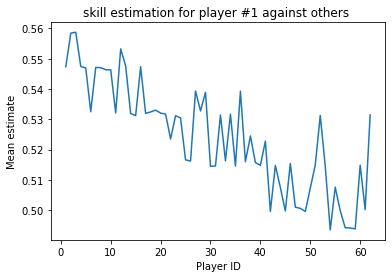

In [16]:
plt.plot(X[1:63],scores1[1:63])
plt.title('skill estimation for player #1 against others ')
plt.xlabel('Player ID')
plt.ylabel('Mean estimate')
plt.show()

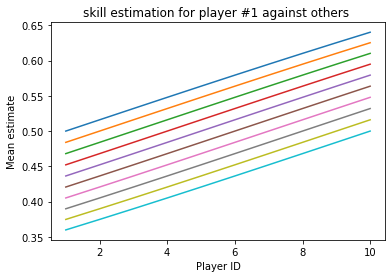

In [17]:
plt.plot([1,2,3,4,5,6,7,8,9,10],Pwin)
plt.title('skill estimation for player #1 against others ')
plt.xlabel('Player ID')
plt.ylabel('Mean estimate')
plt.show()